# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

**Note** we hide the cells of the code and we create chapters. In the left, there is the possibility to see the table of contents, in the case you would like to skip between an analysis and the other.


We hope you are able to see the notebook formated and already run, in the case you don't see please go to **our notebook in the link**:
[our notebook](https://colab.research.google.com/drive/1DJf5sm2lEji442a3P5EMvmDQysbZvm_z?usp=sharing)

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

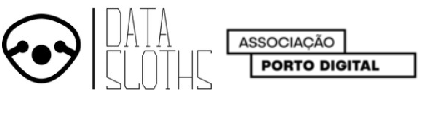

**Predicting traffic flow in Porto using induction loop sensors**


According to the [European Environment Agency](https://www.europarl.europa.eu/news/en/headlines/society/20190313STO31218/co2-emissions-from-cars-facts-and-figures-infographics), passenger cars are a significant polluter, accounting for 60.7% of total CO2 emissions from road transport in Europe.
Data Sloths would like to support the city of Porto in predicting the traffic flow and understanding the factors that influence the
traffic as well as showing the impacts of traffic. This is to develope a strategy to implement measures on short term basis based on a predictive model that predicts traffic flow in various locations in the city of Porto.

💪 **Goal:** create an explainable prediction of when
heavy flow and congestions in the city will happen using sensor data from induction loops.

💪 **Impact:** create tools for the city to manage the traffic much
better by achieving this, thus reducing the CO2 emissions. 


"Traffic congestion increases vehicle emissions and degrades ambient air quality, and recent studies have shown excess morbidity and mortality for drivers, commuters and individuals living near major roadways."[Air pollution and health risks due to vehicle traffic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4243514/#:~:text=Traffic%20congestion%20increases%20vehicle%20emissions,on%20roads%20is%20very%20limited.).

Traffic conjections can cause many other health problems such as stress, fatigue, irritiablity and rage in commuters [Can everyday traffic affect our mental health?](https://www.whiteswanfoundation.org/mental-health-matters/understanding-mental-health/can-everyday-traffic-affect-our-mental-health). 


In [ ]:
#@title
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/VUDV9Pl5fhU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Development
Start coding here! 🐱‍🏍

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

To keep the notebook readable, we decided to divide the **Development** in the following sections:
- packages installations, imports
- functions
- import the data
- eda
- model
- analysis


---

### Packages intallations, imports

In [ ]:
!pip install workalendar

In [ ]:
!pip install plotly==4.14.3

In [ ]:
! pip install geopandas

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from google.colab import drive
import plotly.express as px
from IPython.display import display
import os
import re
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from workalendar.europe import Portugal
from scipy import stats
import numpy as np
import json
import geopandas
import requests
import json
import pandas as pd
import time
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 
import requests
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Functions

In [ ]:
def preproc_df(df):
    df["dateobservedfrom"] = pd.to_datetime(df["dateobservedfrom"])
    df["sensor_id"] = df["entity_id"].apply(lambda x: x[50:])
    df = df.rename(columns={"dateobservedfrom" : "from_date"})
    df = df[["from_date", "sensor_id", "intensity"]]
    return df

#pre-processing the data and set the type to optimize memory
def set_date_features(df):
    df['hour'] = df['from_date'].dt.hour.astype("int16")
    df['weekday'] = df['from_date'].dt.strftime('%A')
    df['day_of_week'] = df['from_date'].dt.dayofweek.astype("int16")
    df['month'] = df['from_date'].dt.month.astype("int16")
    df['year'] = df['from_date'].dt.year.astype("int16")
    cal = Portugal()
    df['holiday'] = df.from_date.apply(lambda x: int(cal.is_working_day(pd.to_datetime(str(x))))).astype("int16")
    df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5 == 1).astype(int).astype("int16")
    return df

#metric for the model
def compute_r2_score(y_test,y_test_pred):
    r2 = r2_score(y_test, y_test_predict)
    return r2

#def mean_absolute_error(y_test,y_test_pred):
#  r2 = mean_absolute_error(y_test, y_test_predict)
#  return r2

#regex search function from sensor id to shower ids
def regex_search(x, regex):
  match = re.search(regex,x)
  if match is not None:
    return match.group(0)
  else:
    return None

def kelvin_to_celsius(f):
  temp = float(f)
  celsius = (temp - 273.15)
  return celsius

def create_weather_df(hist_weather_json):
  weather_ls = []
  for ls in hist_weather_json['list']:
    unixts = int(ls['dt'])
    dt = datetime.utcfromtimestamp(unixts).strftime('%Y-%m-%d %H:%M:%S')
    main = ls['main']
    main_vals = main.values()
    weather_ls.append([dt]+list(main_vals))
  cols = ['datetime']+list(main.keys())
  hist_weather = pd.DataFrame(weather_ls, columns = cols)
  #convert to fahrenheit
  fahrenheit_cols = ['temp','feels_like','temp_min','temp_max']
  for c in fahrenheit_cols:
    hist_weather[c] = hist_weather[c].apply(kelvin_to_celsius)
  return hist_weather

def train_test_split(df, y_col, model_type, splitval = 0.7):
    xtr_idx = int(df.shape[0] * splitval)
    if (model_type != 'sarimax' and model_type != 'sarimax_multiple_one_step'):
        d_X_cols = list(set(df.columns) - set([y_col]))
    else:
        d_X_cols = df.columns
        y_col = df.columns

    X_train= df.iloc[:xtr_idx][d_X_cols]
    y_train= df.iloc[:xtr_idx][y_col]

    X_test = df.iloc[xtr_idx:][d_X_cols]
    y_test = df.iloc[xtr_idx:][y_col]

    dts = df.index

    train_dts = dts[:xtr_idx]
    test_dts = dts[xtr_idx:]

    return X_train, X_test, y_train, y_test, train_dts, test_dts


def preprocess_ML(train_df, X_cols_cat,X_cols_cont, y_col):
    X_cols = X_cols_cat + X_cols_cont
    train_df.sort_index(inplace=True)
    train_df.reset_index(inplace=True)
    train_df = set_date_features(train_df)
    train_df.set_index('from_date',inplace=True)
    train_df = train_df[X_cols+[y_col]]
    train_df = pd.get_dummies(train_df, columns=X_cols_cat, drop_first=True)
    return train_df

def add_missing_feats(X,pred_df_f):
  missing_feats_cols = list(set(X.columns) - set(pred_df_f.columns))
  if len(missing_feats_cols) > 0:
    #add missing to data
    for c in missing_feats_cols:
      pred_df_f[c] = 0
  return pred_df_f
#This function can be used on df_comb after changing the index into datetime . (befor go to model) then by resampling the result the df will be ready to go to the model.
#It will replace outliers and nan values by interpolating the intensity values of each sensor without outliers

def remove_outliers_prev(df,y_col_name,time_cols, method ='removing'):
    df_copy = df.copy()
    y_col = df_copy[[y_col_name]].dropna()
    z = np.abs(stats.zscore(y_col))
    index_ = y_col[(z < 10)].index
    index_outliers = y_col[(z >= 10)].index 
    df_outliers = df_copy.loc[index_outliers,[y_col_name]+time_cols]#+['from_date']]
    if method == 'removing':
        df_ = df_copy.loc[index_,[y_col_name]+time_cols]#+['from_date']]    
    elif method =='clipping':
        df_copy.loc[index_outliers,y_col_name]=np.nan
        df_copy[y_col_name] = df_copy[y_col_name].interpolate()
        df_ = df_copy
    return df_,df_outliers  


def remove_outliers(df,y_col_name,time_cols, method ='removing'):

    df_copy = df.copy()
    y_col = df_copy[y_col_name].dropna()

    z = np.abs(stats.zscore(y_col))
    index_ = y_col[(z < 2)].index
    index_outliers = y_col[(z >= 2)].index 
    print(index_outliers)    
    df_outliers = df_copy.loc[index_outliers, y_col_name+time_cols]#+['from_date']]

    if method == 'removing':
        df_ = df_copy.loc[index_,[y_col_name]+time_cols]#+['from_date']]    
    elif method =='clipping':
        df_copy.loc[index_outliers,y_col_name]=np.nan

    ## Method 1 - Interpolation
        df_copy = df_copy.dropna().interpolate()

    ## Method 2 - Backfill        
    #    df_copy = df_copy.fillna(value=None, method='backfill', axis=None, downcast=None)

      #Method 3 - KNN
        #data_imputed = imputer.fit_transform(df_copy)
        #df_ind_resample_knn = pd.DataFrame(data_imputed, index=df_copy.index, columns=df_copy.columns)

        df_ = df_copy
    return df_,df_outliers   

def predict_period_n(series_, model, number_of_periods_ahead, num_periods_lagged): 
    
        X_train, y_train, X_last_period = prepare_for_prediction(series_, 
                                                             number_of_periods_ahead, 
                                                             num_periods_lagged)
        
        model.fit(X_train, y_train)
        return model.predict(X_last_period.values.reshape(1, -1))
    
    
def predict_n_periods(series_, n_periods, model, num_periods_lagged): 
    predictions = []

    for period_ahead in range(1, n_periods+1):
        pred = predict_period_n(series_=series_, 
                                model=model, 
                                number_of_periods_ahead=period_ahead, 
                                num_periods_lagged=num_periods_lagged)
        
        predictions.append(pred[0])
        
    return predictions 

def prepare_for_prediction(series_, number_of_periods_ahead, num_periods_lagged):
    
    """ 
    Wrapper to go from the original series to X_train, y_train, X_last_period 
    
    """
    
    # build the target 
    data_with_target = build_target(series_, 
                                    number_of_periods_ahead)
    
    # build the features 
    data_with_target_and_features = build_some_features(data_with_target, 
                                                        num_periods_lagged=num_periods_lagged)
    # separate train and test data 
    last_period, training_data = separate_last_day(data_with_target_and_features)

    # separate X_train, y_train, and X_test 
    X_train, y_train, X_last_period = separate_train_and_test_set(last_period, 
                                                           training_data, 
                                                           target='target')
    
    # return ALL OF THE THINGS! (well, actually just the ones we need)
    return X_train, y_train, X_last_period 

def separate_train_and_test_set(last_period_, training_data_, target='target'): 
    
    """ 
    separates training and test set (clue was in the name, really... )
    Ok, we were lazy and left the target hardcoded as 'target'. Shame on us. 
    """
    
    # anything that isn't a target is a feature 
    features = [feature for feature in training_data_.columns if feature != target]
    
    # adding a sneaky little dropna to avoid the missing data problem above 
    X_train = training_data_.dropna()[features]
    y_train = training_data_.dropna()[target]
    
    X_last_period = last_period_[features]
    
    return X_train, y_train, X_last_period

def separate_last_day(df_):
    
    """
    takes a dataset which has the target and features built 
    and separates it into the last day
    """
    # take the last period 
    last_period = df_.iloc[-1]
    
    # the last period is now a series, so it's name will be the timestamp
    training_data = df_.loc[df_.index < last_period.name]

    return last_period, training_data

def build_some_features(df_, num_periods_lagged): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['observed_values'].shift(i)
        
    return df_

def build_target(series_, number_of_periods_ahead):
    """ 
    takes a series, turned it into a dataframe, and adds a new column called target
    This column is the input series, lagged number_of_periods_ahead into the future
    """
    
    # make a copy 
    series_ = series_.copy()
    series_.name = 'observed_values'
    
    # make a dataframe from the series
    df_ = pd.DataFrame(series_)
    
    # the target column will be the input series, lagged into the future
    df_['target'] = series_.shift(-number_of_periods_ahead)
    return df_ 

def remove_outliers1(df,y_col_name, method ='removing'):

    df_copy = df.copy()
    y_col = df_copy[y_col_name].dropna()

    z = np.abs(stats.zscore(y_col))
#    print(z.shape)
#    print(z)
    index_ = y_col[(z < 2)].index
    index_outliers = y_col[(z >= 2)].index 
    #print(index_outliers)    
    df_outliers = df_copy.loc[index_outliers, y_col_name]#+['from_date']]

    if method == 'removing':
        df_ = df_copy.loc[index_,[y_col_name]]#+['from_date']]    
    elif method =='clipping':
        df_copy.loc[index_outliers,y_col_name]=np.nan

    ## Method 1 - Interpolation
        df_copy = df_copy.dropna().interpolate()

    ## Method 2 - Backfill        
    #    df_copy = df_copy.fillna(value=None, method='backfill', axis=None, downcast=None)

      #Method 3 - KNN
        #data_imputed = imputer.fit_transform(df_copy)
        #df_ind_resample_knn = pd.DataFrame(data_imputed, index=df_copy.index, columns=df_copy.columns)

        df_ = df_copy
    return df_,df_outliers   







In [ ]:
#some parameters
time_cols = ['hour','day_of_week','month','year','holiday','is_weekend']
load_raw_data = False
path_traffic="https://raw.githubusercontent.com/CarolBellani/WorldDataLeagueDataSloths/main/data/traffic/df_comb_30abr.gzip"

#for importing data
path_sensor = 'https://wdl-data.fra1.digitaloceanspaces.com/porto-digital/traffic_data/'

ls_fname = [#'traffic_flow_2016.csv','traffic_flow_2017.csv',
            'traffic_flow_2018.csv',
            'traffic_flow_2019.csv',
            'traffic_flow_2020.csv','traffic_flow_2021.csv'] # we need to omit 2016 and 2017 to simplify the import

#config to read data
dict_readcsv_conf = {'usecols':["entity_id", "dateobservedfrom", "intensity", "name"],
                'dtype':{ "intensity": "int16"},
                'encoding':'ISO-8859-1'}

### Import the data

#### Load weather historics and forecast (OpenWeather API)

⚠️ **If this runs too long, please stop execution and start again as there seem to be a problem with getting the data from API** ⚠️



In [ ]:
#@title
#load in weather data to include as exogenous
api_key = "4a4027677a29ff7f2fd7c439ad85efe0"
city = "Porto"
countrycode = "PT"
unix_oneday = 86400

end = int(time.time()) #now
start = end - (365 * unix_oneday) #last 12 months

#can only load 7 days at once (use 5 below)
unix_days = unix_oneday * 5
iterations = int((end-start) / (unix_days))

#reset end
end = start + unix_days
hist_df_ls = [] 
for i in range(iterations):

  his_url = "http://history.openweathermap.org/data/2.5/history/city?q=%s,%s&start=%s&end=%s&appid=%s" % (city,countrycode,start,end,api_key)
  response = requests.get(his_url)
  hist_weather_json = json.loads(response.text)

  b = True
  while b:
      try:
          hist_weather_df = create_weather_df(hist_weather_json)
          b = False
      except:
          pass
  
  hist_df_ls.append(hist_weather_df)
  start += unix_days
  end += unix_days

hist_weather_df = pd.concat(hist_df_ls)
hist_weather_df.drop_duplicates()
print("historical weather data examples")
display(hist_weather_df.head(3))

# load weather forecast
for_url = 'http://pro.openweathermap.org/data/2.5/forecast/hourly?q=%s&appid=%s' % (city,api_key)
response = requests.get(for_url)
weather_forecast_json = json.loads(response.text)
forecast_weather_df = create_weather_df(weather_forecast_json)
print("new forecasting data examples")
display(forecast_weather_df.head(3))

historical weather data examples


datetime   temp  feels_like  ...  humidity  temp_min  temp_max
0  2020-05-01 12:00:00  15.68       13.98  ...       100     15.56      16.0
1  2020-05-01 13:00:00  16.13       14.95  ...       100     15.56      17.0
2  2020-05-01 14:00:00  16.13       14.95  ...       100     15.56      17.0

[3 rows x 7 columns]

new forecasting data examples


datetime   temp  feels_like  ...  grnd_level  humidity  temp_kf
0  2021-05-01 12:00:00  15.45       14.70  ...        1005        63     1.14
1  2021-05-01 13:00:00  15.27       14.42  ...        1005        60     0.71
2  2021-05-01 14:00:00  15.09       14.14  ...        1005        57     0.55

[3 rows x 10 columns]

#### Load the air quality and noises data 2018

**Reading about the chemical components**
- CO (Carbon monoxide)-> from gasoline engines
- NO2 (Nitrogen Dioxide)-> diesel
- 03 (Trioxygen) -> good to have, avoid that UV radiation arrive in the superficies
- Ox (NO2+03)
- Fine particulate matter (PM + diameter) -> tossic

Sum: CO+ NO2+ PMs -> if high value, means very polluted

**Noise**

laeq: A-weighted, equivalent continuous sound level (in dB)

In [ ]:
#@title
path_quality = 'https://wdl-data.fra1.digitaloceanspaces.com/porto-digital/air_quality/'
ls_quality=['air_quality_2018.csv','air_quality_2019.csv','air_quality_2020.csv','air_quality_2021.csv']

path_noise = 'https://wdl-data.fra1.digitaloceanspaces.com/porto-digital/noise_level/'
ls_quality=['noise_level_2018.csv','noise_level_2019.csv','noise_level_2020.csv','noise_level_2021.csv']

df_quality_2018 = pd.read_csv(os.path.join(path_quality,'air_quality_2018.csv'), encoding="latin-1")
df_quality_2018['sum_badquality_metric']=df_quality_2018['co']+df_quality_2018['no2']+df_quality_2018['pm1']+df_quality_2018['pm25']+df_quality_2018['pm10']
print("show quality data 2018")
display(df_quality_2018.head(2))

df_noise_2018 = pd.read_csv(os.path.join(path_noise,'noise_level_2018.csv'), encoding="latin-1")
print("show noise data 2018")
display(df_noise_2018.head(2))

show quality data 2018


dateobserved  ... sum_badquality_metric
0  2018-06-29 22:27:33  ...            581.200014
1  2018-06-29 22:32:05  ...            568.700012

[2 rows x 16 columns]

show noise data 2018


dateobserved  ...      name
0  2018-06-29 23:11:55  ...  Clérigos
1  2018-06-29 23:16:56  ...  Clérigos

[2 rows x 9 columns]

#### Load raw data (takes a while, as default load_raw_data is set to False)

In [ ]:
if load_raw_data:
    ls_sensor_dfs = []
    for fname in ls_fname:
        df = pd.read_csv(path_sensor+fname,
                  usecols=dict_readcsv_conf['usecols'],
                  dtype=dict_readcsv_conf['dtype'],
                  encoding=dict_readcsv_conf['encoding'])
        df_f1 = preproc_df(df)

      #df_f1 = set_date_features(df_preproc)
      #df_f1 = reduce_timefields_size(df_f1)

        df_f1["from_date"] = pd.to_datetime(df_f1["from_date"])
        df_f1 = df_f1[['from_date', 'sensor_id', 'intensity']]
        df_comb_p = df_f1.pivot_table(index='from_date', columns='sensor_id', values='intensity')
        ls_sensor_dfs.append(df_comb_p)



In [ ]:
if load_raw_data:
    df_comb = pd.concat(ls_sensor_dfs, ignore_index=False)
    df_comb.rename(columns = {"mLight:0_1":"Light_0_1", "mLight:0_2":"Light_0_2",
                            "mLight:0_3":"Light_0_3", "mLight:0_4":"Light_0_4",
                            "mLight:0_5":"Light_0_5", "mLight:0_6":"Light_0_6"},
                inplace=True)

In [ ]:
#mount drive
if load_raw_data:
  drive.mount('/content/drive/')
  mount_path = "/content/drive/MyDrive/WorldDataLeague_DataSloths/Stage2/challenge1"


In [ ]:
if load_raw_data:
    df_comb.to_parquet(os.path.join(mount_path,'df_comb_30abr.gzip'),
                compression='gzip')

#### Load pre-processed data (as default we import the data of the sensors from git)

In [ ]:
#@title
# dates as index and sensor name with intensity values
df_comb = pd.read_parquet(path_traffic)
#df_comb = df_comb.reset_index().drop(columns=[''])
#df_comb = set_date_features(df_comb)
print("How our dataset looks like")
display(df_comb.tail(5))

How our dataset looks like


CT10Z2  CT10Z3  CT10Z4  ...  CT7Z4  CT8Z4  CT9Z4
from_date                                    ...                     
2021-04-09 05:30:00     1.0     NaN     NaN  ...    NaN    NaN    NaN
2021-04-09 05:35:00     NaN     NaN     NaN  ...    NaN    NaN    NaN
2021-04-09 05:40:00     NaN     NaN     NaN  ...    NaN    NaN    NaN
2021-04-09 05:45:00     2.0     NaN     NaN  ...    NaN    NaN    NaN
2021-04-09 05:50:00     1.0     NaN     NaN  ...    NaN    NaN    NaN

[5 rows x 124 columns]

### EDA

For simplicity, we are looking to the data of the traffic sensors from 2018.

#### Missing values overview

In [ ]:
#@title
#missing values by sensor
df_count_na=df_comb.isna().sum().sort_values(ascending=True).reset_index(name="Missing_values")
fig = px.bar(df_count_na.tail(40), x='Missing_values', y='index', orientation="h", height=1200, width=1000)
fig.update_layout(title="Top 40 sensors with higher missing values count")
fig.show()

We have huge number of missing values, then let's analyse them!
Let's see what happens when we resample at hourly interval, taking the mean of the reading, i.e. getting the average sensor intensity for that hour

#### Resample at Hourly interval

In [ ]:
#@title
df_comb_resampled_hour = df_comb.resample("1H").mean().round()
df_comb_resampled_hour = df_comb_resampled_hour.drop(columns=[''])
print("show the data at hourly interval")
display(df_comb_resampled_hour.head(3))

show the data at hourly interval


CT10Z2  CT10Z3  CT10Z4  ...  CT7Z4  CT8Z4  CT9Z4
from_date                                    ...                     
2017-12-31 00:00:00    19.0     NaN     2.0  ...    NaN    NaN    NaN
2017-12-31 01:00:00    16.0     NaN     2.0  ...    NaN    NaN    NaN
2017-12-31 02:00:00    15.0     NaN     1.0  ...    NaN    NaN    NaN

[3 rows x 123 columns]

#### Deep dive in missing values analysis

Here we look for time periods where ALL sensor values are missing

In [ ]:
#@title
null_hours = df_comb_resampled_hour.index[df_comb_resampled_hour.isnull().all(1)]
print( f'{len(null_hours)} hour intervals without any sensor measurements')
null_hours_dt = null_hours.to_pydatetime()

541 hour intervals without any sensor measurements


Text(0.5, 1.0, 'Histogram of Missing Sensor Measurements by Datetime')

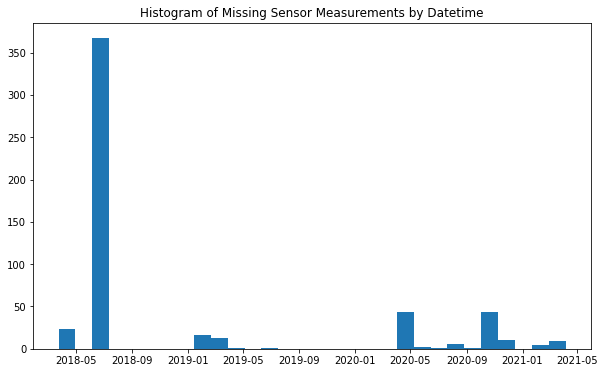

In [ ]:
#@title
fig = plt.figure(figsize=(10, 6))
plt.hist(null_hours_dt, bins=30)
plt.title("Histogram of Missing Sensor Measurements by Datetime")

**Observation** - looks like there is a lot of missing measurements over the years. Looking at the graph, it might be **better to focus on data from 2019, as there are less missing entries**


Let's evaluate based on just 2019 data, see which sensors have the most records/intesity records

In [ ]:
#@title

df_comb_resampled_hour_1=df_comb_resampled_hour.copy()
df_comb_resampled_hour_1['year'] = df_comb_resampled_hour_1.index.year
df_comb_resampled_hour_1_2019=df_comb_resampled_hour_1[df_comb_resampled_hour_1['year']==2019]
df_comb_resampled_hour_1_2019.drop(['year'], axis=1, inplace=True)
df_2019_na=df_comb_resampled_hour_1_2019.isna().sum().sort_values(ascending=True).reset_index(name="Missing_values")
fig = px.bar(df_2019_na, x='Missing_values', y='index', orientation="h", height=1200, width=1000)
fig.update_layout(title="Missing values 2019")
fig.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We see that the last 30 sensors have few missing values finally!
Let's geolocalize them and select a subset that is in the same area of Porto.
In the next chapter we will see before an overview and after the focus in these 30 sensors with less missing data of 2019.

#### Sensor, how many? where? Geo-location

In [ ]:
#@title
print("How many sensors do we have? of which type?")
path = "https://wdl-data.fra1.digitaloceanspaces.com/porto-digital/data_entities.csv"
df_dataenti=pd.read_csv(path, encoding="latin-1")
display(df_dataenti['entity_type'].value_counts().reset_index(name="Counts"))
df_dataenti=df_dataenti[df_dataenti['longitude']!='WeatherObserved']
gdf = geopandas.GeoDataFrame(
    df_dataenti, geometry=geopandas.points_from_xy(df_dataenti.longitude, df_dataenti.latitude))
gdf.crs = "EPSG:4326"

#extract sensor from entity_id
regex = '[a-zA-Z]{1,2}\d{1,2}[a-zA-Z]{1,2}\d{1,2}'
gdf['sensor'] = gdf.entity_id.apply(lambda x: regex_search(x, regex))

How many sensors do we have? of which type?


index  Counts
0  TrafficFlowObserved     130
1      WeatherObserved      28
2   NoiseLevelObserved      18
3   AirQualityObserved      10

In [ ]:
#@title
print("Localization of the sensors using coordinates - the colors represent different type of measurements")
fig = px.scatter_mapbox(gdf, lat="latitude", lon="longitude", color="entity_type", center={'lon':-8.61099,'lat':41.14961},zoom=11, text='sensor')
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Localization of the sensors using coordinates - the colors represent different type of measurements


Looking to the map we see that the following sensors:
- CT11Z3 traffic
- a8af1 noise
- e7ea54 quality

are close to each other and they are of different type, we are going to study them to see the traffic and air/noise possible correlation

#### Geo-location 30 sensors with few missing data in 2019

In [ ]:
#@title
gdf2 = gdf[gdf.sensor.isin(df_2019_na[:30]['index'])]
fig = px.scatter_mapbox(gdf2, lat="latitude", lon="longitude", color="entity_type", center={'lon':-8.61099,'lat':41.14961},zoom=11, text='sensor')
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Observation - We decided to select a group of sensors that have less missing values, and that they are clustered in a region separate to other areas

In [ ]:
#@title
selected_sensors = ["CT3Z7", "CT4Z7", "CT5Z7", "CT6Z7", "CT7Z7", "CT8Z7", "CT9Z7"]
gdf_sel = gdf[gdf.sensor.isin(selected_sensors)]
fig = px.scatter_mapbox(gdf_sel, lat="latitude", lon="longitude", color="entity_type", center={'lon':-8.61099,'lat':41.14961},zoom=11, text='sensor')
fig.update_layout(title_x = 0.25, title_text="Selected Sensors")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
#@title
print("Now the data looks like this:")
df_comb_resampled_hour_subset = df_comb_resampled_hour[selected_sensors]
display(df_comb_resampled_hour_subset.head(5))

Now the data looks like this:


CT3Z7  CT4Z7  CT5Z7  CT6Z7  CT7Z7  CT8Z7  CT9Z7
from_date                                                           
2017-12-31 00:00:00   22.0   51.0   28.0    4.0   14.0   14.0    8.0
2017-12-31 01:00:00   18.0   29.0   16.0    3.0    7.0    8.0    5.0
2017-12-31 02:00:00   11.0   20.0   11.0    2.0    5.0    7.0    4.0
2017-12-31 03:00:00    6.0   12.0    7.0    2.0    2.0    3.0    2.0
2017-12-31 04:00:00    6.0   10.0    5.0    1.0    2.0    4.0    2.0

#### POIs geo-location

In [ ]:
#@title
r = requests.get('https://wdl-data.fra1.digitaloceanspaces.com/porto-digital/POIs.json')
pois=r.json()
print("we have ",len(pois['points_of_interest']), "POIs")
df_pois = pd.DataFrame(pois['points_of_interest'])

df_pois['category_en_value']=df_pois['category'].apply(lambda x: x[1]['value'])
df_pois['description_en_value']=df_pois['description'].apply(lambda x: x[1]['value'])

print("Most frequent 10 POIs categories")
display(df_pois['category_en_value'].value_counts().reset_index(name="Count").head(10))

def get_coord(x):
  try:
    return x['point'][0]['Point']['posList']
  except:
    return "nopoint"
df_pois['location_point']=df_pois['location'].apply(lambda x: get_coord(x))

df_pois=df_pois[df_pois['location_point']!="nopoint"] #5cd04b56f979e000012c5e2b id doesn't have the point -.-

df_pois['latitude']=df_pois['location_point'].apply(lambda x: x.split(" ")[0])
df_pois['longitude']=df_pois['location_point'].apply(lambda x: x.split(" ")[1])

gdf_poi = geopandas.GeoDataFrame(
    df_pois, geometry=geopandas.points_from_xy(df_pois.longitude, df_pois.latitude))

gdf_poi.crs = "EPSG:4326"

gdf_poi['Center_point'] = gdf_poi['geometry'].centroid
gdf_poi['lon'] = gdf_poi.Center_point.x
gdf_poi['lat'] = gdf_poi.Center_point.y

we have  1910 POIs
Most frequent 10 POIs categories


index  Count
0                            Shops    272
1                      Restaurants    212
2                       Pharmacies    108
3                           Hotels     91
4  Statues, Sculptures & Fountains     69
5                        Monuments     62
6       Museums & Thematic Centres     62
7                Transport company     60
8                              Bar     58
9             Local accommodations     57

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [ ]:
#@title
print("Geo-localization of POIs")
fig = px.scatter_mapbox(gdf_poi, lat="lat", lon="lon", color="category_en_value", center={'lon':-8.61099,'lat':41.14961},zoom=11)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Geo-localization of POIs


#### Intensity over the time all the sensors, all the years considered (>2018)

In [ ]:
#@title
def show_sensor_plot(df, sensor_name):
  #if year != "All":
  #  df_plot = df[year]
  #else:
  df_plot = df
  fig = px.line(df_plot, y=sensor_name, x =df_plot.index)
  #fig.update_xaxes(rangeslider_visible=True)
  fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                    buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(step="all")
                                ])
                            )
                        )
  fig.update_layout( width=1500, height=800,title_x = 0.25, title_text=f"Plot for Sensor {sensor_name}")
  fig.show()

sensor_widget = widgets.Dropdown(
    options=df_comb_resampled_hour.columns,
    description='Sensor name'
)


interact(lambda sens: show_sensor_plot(df_comb_resampled_hour, sens), 
        sens = sensor_widget)

interactive(children=(Dropdown(description='Sensor name', options=('CT10Z2', 'CT10Z3', 'CT10Z4', 'CT10Z5', 'CT…

<function __main__.<lambda>>

#### Intensity over the time for 2019 and for the 6 sensors with less missing values

In [ ]:
#@title
def show_sensor_plot(df, sensor_name):

  df_plot = df
  fig = px.line(df_plot, y=sensor_name, x =df_plot.index)
  fig.update_xaxes(rangeslider_visible=True)
  fig.update_layout( width=1500, height=800,title_x = 0.25, title_text=f"Plot for Sensor {sensor_name}")
  fig.show()

sensor_widget = widgets.Dropdown(
    options=selected_sensors,
    description='Sensor name'
)

year_widget = widgets.Dropdown(
    options=["All", "2018", "2019", "2020", "2021" ],
    description='Year'
)

interact(lambda sens: show_sensor_plot(df_comb_resampled_hour_1_2019, sens), 
        sens = sensor_widget)

interactive(children=(Dropdown(description='Sensor name', options=('CT3Z7', 'CT4Z7', 'CT5Z7', 'CT6Z7', 'CT7Z7'…

<function __main__.<lambda>>

Observation - having checked the values for all 7 sensors in 2019 we see that there is not a lot of missing values, and also that the outliers caused by acquisition errors occur quite infrequently. So we decide on the following:

Use interpolation to impute the missing values
replace the outliers with series mean

#### Outliers analysis for the 7 sensors with less missing values in 2019

before imputation


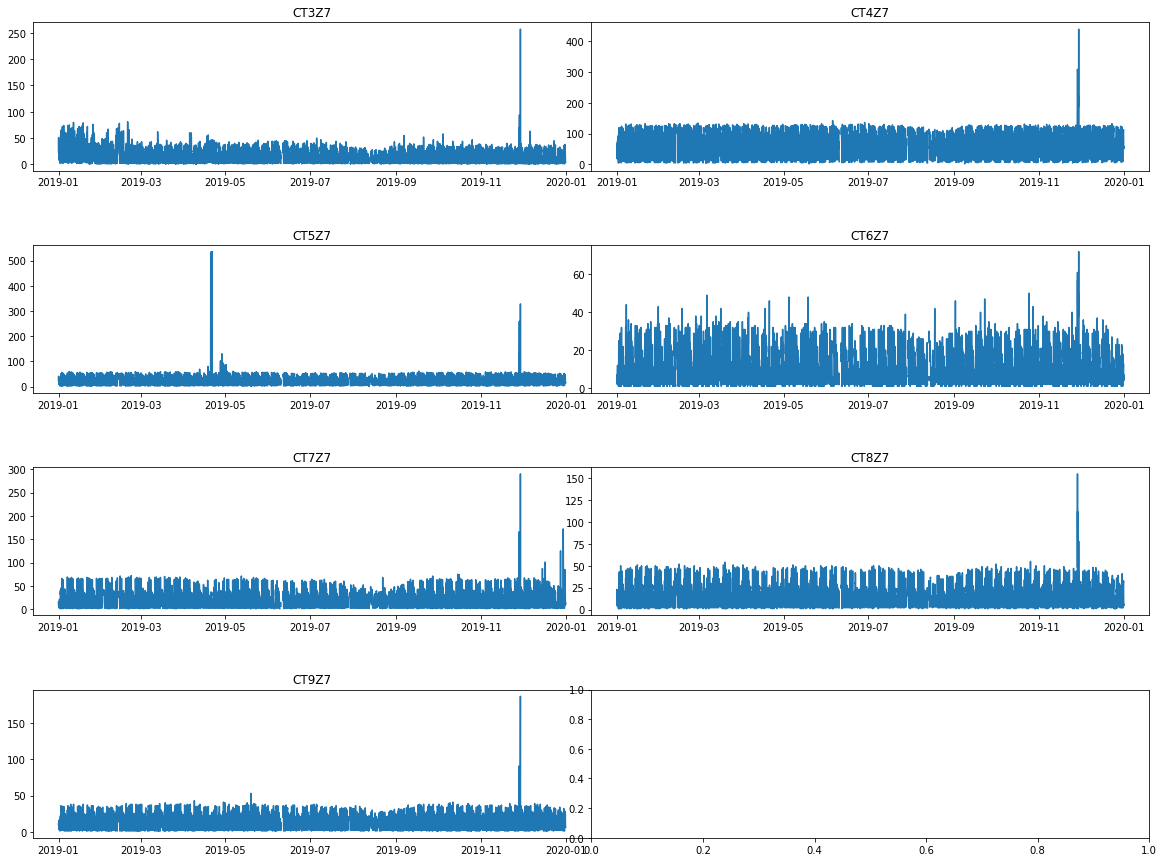

In [ ]:
#@title
print("before imputation")
fig, axs = plt.subplots(4,2, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(7):

    axs[i].plot(df_comb_resampled_hour_1_2019[selected_sensors[i]])
    axs[i].set_title(selected_sensors[i])

In [ ]:
#@title
df_comb_resampled_hour_1_2019.reset_index(inplace=True)
set_date_features(df_comb_resampled_hour_1_2019)
df_comb_resampled_hour_1_2019.set_index('from_date',inplace=True)
df_new_train_test,df_new_train_test_outliers = remove_outliers1(df_comb_resampled_hour_1_2019[selected_sensors], selected_sensors, method ='clipping')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

after imputation


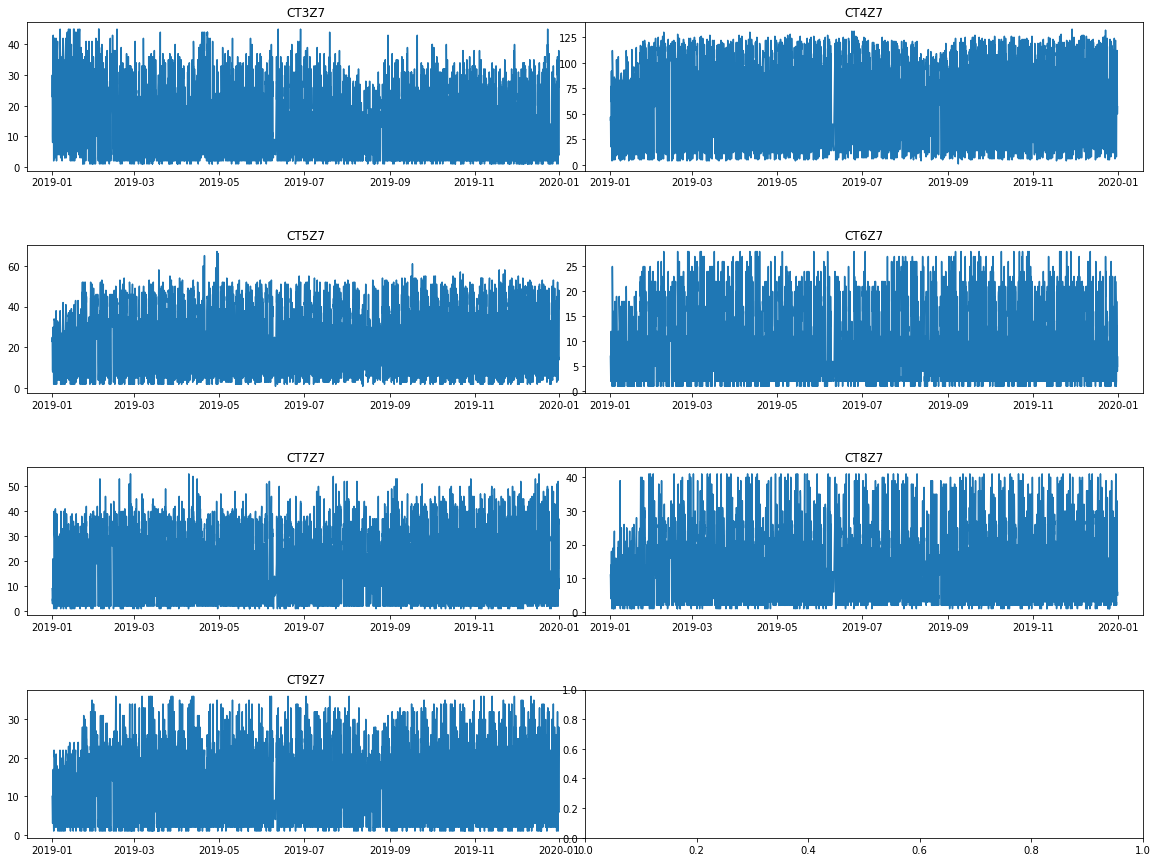

In [ ]:
#@title
print("after imputation")
fig, axs = plt.subplots(4,2, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(7):

    axs[i].plot(df_new_train_test["2019"][selected_sensors[i]])
    axs[i].set_title(selected_sensors[i])

**Let's look at the Autocorrelation and Partial-Autocorrelation plots for one of the sensors (CT7Z7)**

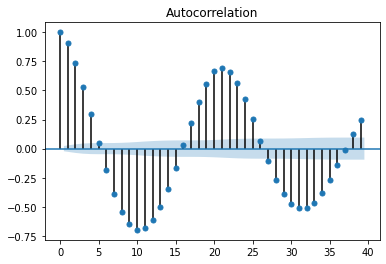

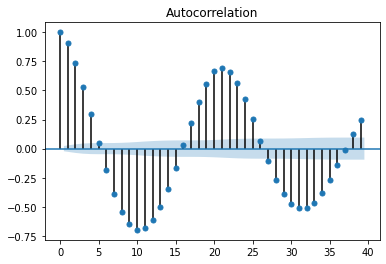

In [ ]:
#@title
plot_acf(df_new_train_test["CT4Z7"])

The Autocorrelation graph suggest correlation between each time lag, as expected for a moving average time-serie. The seasonality occurred around 20


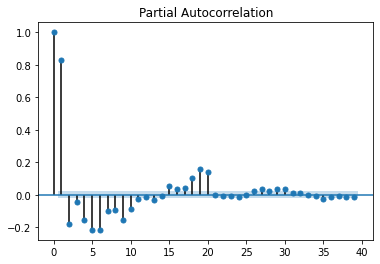

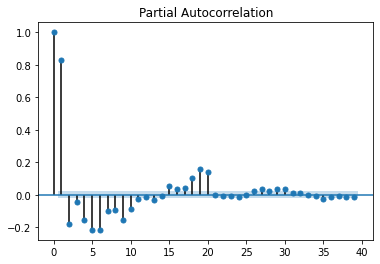

In [ ]:
#@title
plot_pacf(df_new_train_test["CT7Z7"])

Let's see the correlation when sampled at a Daily level

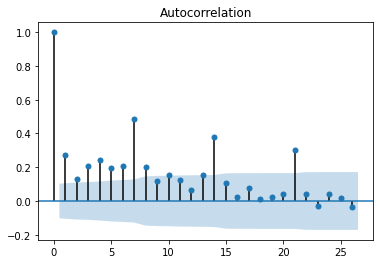

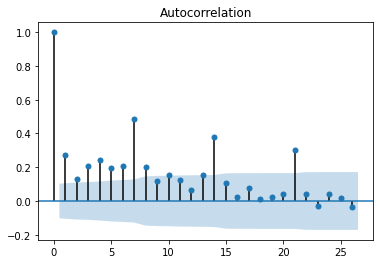

In [ ]:
#@title
df_d = df_new_train_test["CT7Z7"].resample('1D').mean()
plot_acf(df_d)

Here we can see a seasonlity of 7 days

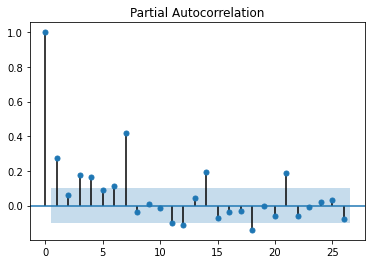

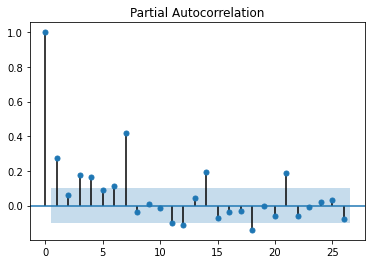

In [ ]:
#@title
plot_pacf(df_d)

#### Analysis correlation between traffic and air quality and noise

Consider only:
- CT11Z3 traffic
- a8af1 noise
- e7ea54 quality


in 2018


**The following plots show that high traffic flow leads to higher airpollution and noise. This is quite an important finding as this is part of our strategy to reduce CO2 emissions and noise.**

In [ ]:
#@title
df_comb_1=df_comb.reset_index()
df_sensor=df_comb_1[['from_date','CT11Z3']]
df_sensor['from_date_year']=df_sensor['from_date'].dt.year
df_sensor=df_sensor[df_sensor['from_date_year']==2018]
display(df_sensor.tail(2))
df_noise_2018['dateobserved']=pd.to_datetime(df_noise_2018["dateobserved"])
df_noise_2018['sensor'] = df_noise_2018.entity_id.apply(lambda x: regex_search(x, regex))
df_noise_2018_sensor=df_noise_2018[df_noise_2018['sensor']=='a8af1']
df_noise_2018_sensor=df_noise_2018_sensor[['dateobserved','laeq','sensor']]
display(df_noise_2018_sensor.head(2))
df_quality_2018['dateobserved']=pd.to_datetime(df_quality_2018["dateobserved"])
df_quality_2018['sensor'] = df_quality_2018.entity_id.apply(lambda x: regex_search(x, regex))
df_quality_2018_sensor=df_quality_2018[df_quality_2018['sensor']=='e7ea54']
df_quality_2018_sensor=df_quality_2018_sensor[['dateobserved','sum_badquality_metric','sensor']]
display(df_quality_2018_sensor.head(2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



from_date  CT11Z3  from_date_year
100871 2018-12-31 23:50:00     NaN            2018
100872 2018-12-31 23:55:00    12.0            2018

dateobserved       laeq sensor
197910 2018-06-29 18:56:52  72.800003  a8af1
197911 2018-06-29 19:01:54  72.800003  a8af1

dateobserved  sum_badquality_metric  sensor
0 2018-06-29 22:27:33             581.200014  e7ea54
1 2018-06-29 22:32:05             568.700012  e7ea54

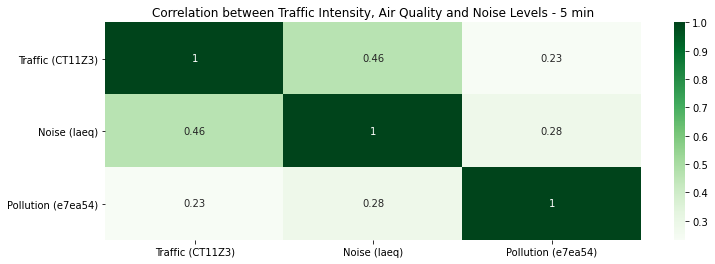

In [ ]:
# @title
## resample at 5 min
df_quality_2018_sensor_r = df_quality_2018_sensor.set_index("dateobserved").resample("5T").mean()
df_noise_2018_sensor_r = df_noise_2018_sensor.set_index("dateobserved").resample("5T").mean()
df_fin = pd.merge(df_sensor, df_noise_2018_sensor_r, left_on ="from_date", right_on="dateobserved")
df_fin2 = pd.merge(df_fin, df_quality_2018_sensor_r, left_on ="from_date", right_on="dateobserved")
df_fin2.set_index("from_date", inplace=True)
df_fin3 = df_fin2[['CT11Z3', 'laeq', 'sum_badquality_metric']]
corr_matrix = df_fin3.corr(method='spearman')

axis_labels = ["Traffic (CT11Z3)","Noise (laeq)", "Pollution (e7ea54)"] 

plt.figure(figsize = (12,4)) # <-- just sets the figure size
plt.title("Correlation between Traffic Intensity, Air Quality and Noise Levels - 5 min")
sns.heatmap(corr_matrix,
annot=True, # <-- write the numbers on the squares
cmap='Greens', xticklabels=axis_labels, yticklabels=axis_labels);

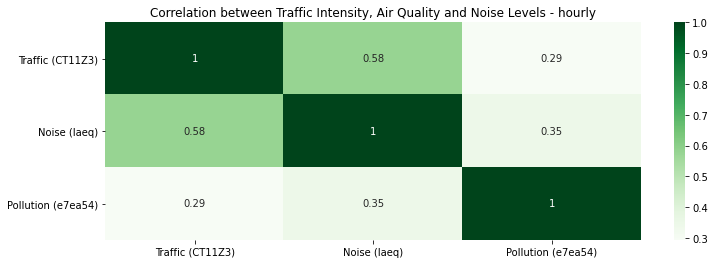

In [ ]:
# @title
## resample at 1 hour
df_sensor_rh = df_sensor.set_index("from_date").resample("1H").mean()
df_quality_2018_sensor_rh = df_quality_2018_sensor.set_index("dateobserved").resample("1H").mean()
df_noise_2018_sensor_rh = df_noise_2018_sensor.set_index("dateobserved").resample("1H").mean()
df_sensor_rh.reset_index(inplace=True)
df_finh = pd.merge(df_sensor_rh, df_noise_2018_sensor_rh, left_on ="from_date", right_on="dateobserved")
df_finh2 = pd.merge(df_finh, df_quality_2018_sensor_rh, left_on ="from_date", right_on="dateobserved")

df_finh2.set_index("from_date", inplace=True)
df_finh3 = df_finh2[['CT11Z3', 'laeq', 'sum_badquality_metric']]
corr_matrix = df_finh3.corr(method='spearman')

axis_labels = ["Traffic (CT11Z3)","Noise (laeq)", "Pollution (e7ea54)"] 

plt.figure(figsize = (12,4)) # <-- just sets the figure size
plt.title("Correlation between Traffic Intensity, Air Quality and Noise Levels - hourly")
sns.heatmap(corr_matrix,
annot=True, # <-- write the numbers on the squares
cmap='Greens', xticklabels=axis_labels, yticklabels=axis_labels);

**Observation:** There is quite a strong correlation between Traffic Intensity and Noise, as shown by the heatmap above. When sampled at 5 min intervals, the correlation is 0.46. This increases to 0.58 when sampled hourly. Secondly there is also correlatin between noise and air pollution, and traffic intensity and air pollution.

The plot below shows the Traffic Intensity, Noise Level and Air Pollution verus time. It validates the correlation we measured above, and in fact the Traffic Intensity and Noise almost mirror each other, and in some cases the Air pollution also closely relate to the traffic intensity.

In [ ]:
# @title
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_fin3.index, y=df_fin3['sum_badquality_metric']/10,name="air pollution (divided by 10)"))
fig.add_trace(go.Scatter(x=df_fin3.index, y=df_fin3['laeq'], name="noise"))
fig.add_trace(go.Scatter(x=df_fin3.index, y=df_fin3['CT11Z3'], name="traffic"))
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                    buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(step="all")
                                ])
                            )
                        )
fig.update_layout( width=1500, height=800,title_x = 0.25, title_text=f"Plot for Traffic Intensity, Noise level and Air Pollution - 5 min")
fig.show()

### Model

#### SARIMAX & ML approach

Here explore different Model approaches. The main problem is the the underlying data for some of the sensors as shown in EDA. Due to the time contraints we decided to build a simple model that removes time intervals with missing data. with enough historic data this should not cause any problems as for the missing intervals we have enough other time periods. Therefore we decided to use a **RandomForest regressor as our first Mockup model**. But we already explored the possibilities of outlier removal and interpolation which is crucial for time series model like SARIMAX as we cant have missing interval to train these models. In our code we have set options for RandomForest and Sarimax which incooperate different preprocessing steps for each of them, this can be used in the future improve model accuracy and chose the model which is more suitable.

In [ ]:
# @title
#a forecast for each sensor:
cols = df_comb.columns
#just get the traffic sensors
traffic_sensors = [col for col in cols if re.search("CT",col)]

In [ ]:
# @title
try:
  df_comb.set_index('from_date', inplace=True)
except:
  pass

In [ ]:
# @title
#model set up
y_col = 'intensity'
#model_type = 'sarimax'
#model_type = 'sarimax_multiple_one_step'
model_type = 'ml'
rf_reg_params = {'n_estimators':20,'max_depth':100,'min_samples_split':100,'min_samples_leaf':30,'random_state':0}
X_cols_cat = ['hour','weekday','is_weekend','holiday']
X_cols_cont = ['temp']
resample='1H'

In [ ]:
# @title
#crate a prediction dataset that we use to predict from now + 1 hour --> + 3 days
import datetime as dt
now = dt.datetime.now()
now_hour = dt.datetime(now.year, now.month, now.day,now.hour,0,0)
pred_dt_rg = pd.date_range(start= now_hour,end=now_hour+dt.timedelta(days=3), freq=resample)
hist_weather_df.datetime = pd.to_datetime(hist_weather_df.datetime)
forecast_weather_df.datetime = pd.to_datetime(forecast_weather_df.datetime)

In [ ]:
# @title 
traffic_sensors_top30 = gdf[gdf.sensor.isin(df_2019_na[:30]['index'])].sensor

The **model creates a forecast for all sensors**  using different time features : hour, weekday, is weekend and holida flag as categorical variables. We also include the temp as one the input variables. The model can be trained in different time ranges of dates. Based on the previous analysis we saw that 2019 seems to be most clean time period accross all sensor. If the model would run in production we can explore option to use more recent data as well. Due to covid it is more difficult to make assumption about which data to use as also behaviour how we travel and commute changes. Therefore we decided for simplicity to use the last 12 months of data as incooperates covid period with and without lockdown. It is not certain how this crisis will develop. We would ensure that the assumption we make about the training are feasible for a  model going foward.

In the following print statement we see r2score as one of the measures we used (we also used mean absolute error etc.) We understand that other metrics besides r2 could be more useful. We think for this problem to evaluate low to high traffic flow it seems feasible. The next step based on the results below is to remove sensor models (predictions) for models that are not performing well (low or negative r2 score) Setting the treshold to at 0.4 seems acceptable.

In [ ]:
# @title
sarimax_dict = {}
r2scores = {}
results_dict = {}
#traffic_sensors = ['CT4Z10']
train_test_days = 365
dtrg_19 = pd.date_range(start='1/1/2019', end='1/1/2020', freq='H')
pred_df_ls = []
for traffic_sensor in traffic_sensors:

    #easiest to dropna as we should have enough data per sensor for prediction
    # TODO - function
    #exclude any resampled period with nan's (when not resampled - na_idx)
    # a function to ommit an hourly interval with any missing data
    na_idx = df_comb[df_comb[traffic_sensor].isna()][traffic_sensor].resample(resample).sum().index
    sensor_intensity = df_comb[traffic_sensor]
    if (model_type =='sarimax' or model_type == 'sarimax_multiple_one_step'):
      sensor_intensity = sensor_intensity.interpolate()
    else:
      sensor_intensity = sensor_intensity[~sensor_intensity.index.isin(na_idx)]
    sensor_intensity = sensor_intensity.resample(resample).sum().dropna()
  #train with latest data
  #use latest X months/days to train model 
    st_idx = -24*train_test_days
  #use 4 month or less
    st_idx = 0 if st_idx > sensor_intensity.shape[0] else st_idx

    #train = sensor_intensity.loc[dtrg_19]
    train = sensor_intensity[st_idx:]
    train.index = pd.DatetimeIndex(train.index).to_period(resample)

    #add weather 
    tr = train.reset_index()
    tr.from_date = pd.to_datetime(tr.from_date.astype(str))
    tr = pd.merge(tr,hist_weather_df[['datetime','temp']], how='left', right_on='datetime',left_on='from_date')
    tr.index = pd.DatetimeIndex(tr.from_date).to_period(resample)
    tr.drop(columns=['from_date','datetime'], inplace=True)

    train_df = tr.copy()

    #train_df = train.to_frame(traffic_sensor)
    train_df = train_df.dropna(subset=['temp']) #
    train_df = preprocess_ML(train_df,X_cols_cat,X_cols_cont, traffic_sensor) if (model_type != 'sarimax' and model_type != 'sarimax_multiple_one_step') else train_df
    X_train, X_test, y_train, y_test, train_dts, test_dts = train_test_split(train_df,traffic_sensor,model_type)

  #apply interpolation?

  #apply data checks?

  #autmatic data pattern check
    # constant value etc.
  #try: #try except to get around linear algebra error during sarimax (implement data checks to avoid)
  #train sarimax
  #instead of ifelse - create regressor class and pass params as **kwargs?
    if model_type =='sarimax':
        arima = SARIMAX(X_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 24), trend='n') # these have been previously found via an automatic method
        arima_results = arima.fit()
        arima_predictions = arima_results.predict() 
        y_test_predict = arima_results.predict(start=y_test.index.min(),end=y_test.index.max())
        y_test_predict = y_test_predict[y_test_predict.index.isin(y_test.index)]
    elif model_type == 'sarimax_multiple_one_step':
        sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=24)
        sarimax_forecast_one_step_refit = []
        sarimax.fit(X_train)         
        for i in np.arange(0,len(y_test)): 
            next_step_forecast = sarimax.predict(1)[0]
            sarimax_forecast_one_step_refit.append(next_step_forecast)
            sarimax = sarimax.update(y_test[i:i+1])
        y_test_predict = sarimax_forecast_one_step_refit
    else:
        regr = RandomForestRegressor(**rf_reg_params)
        regr.fit(X_train, y_train)
        y_test_predict = regr.predict(X_test)
     
  #need validation, use metrics to check each sensor model

    r2 = compute_r2_score(y_test, y_test_predict)
  #Mean absolute percentage error
  #TODO
    print(traffic_sensor, "; r2_score test: ",round(r2,2),"; data records: ", train.shape[0], 'avg traffic per hour :', round(np.mean(y_test),1))
    results_dict[traffic_sensor] = (r2,y_test,y_test_predict,test_dts,train.shape[0],np.mean(y_test))

  #prediction 
    pred_df = pd.DataFrame(data=pred_dt_rg, columns=['from_date'])
    pred_df[traffic_sensor] = np.nan

    #add weather 
    pred = pred_df.reset_index()
    pred.from_date = pd.to_datetime(pred.from_date.astype(str))
    pred = pd.merge(pred,forecast_weather_df[['datetime','temp']], how='left', right_on='datetime',left_on='from_date')
    pred.index = pd.DatetimeIndex(pred.from_date).to_period(resample)
    pred.drop(columns=['from_date','datetime'], inplace=True)

    pred_df = pred.copy()
    pred_df_f = preprocess_ML(pred_df,X_cols_cat,X_cols_cont, traffic_sensor)
    pred_df_f.drop(columns=traffic_sensor,inplace=True)
    X = pd.concat((X_train,X_test),axis=0)
    y = pd.concat((y_train,y_test),axis=0)
    regr.fit(X, y)
    #check input feature are present in pred_df_f
    pred_df_f = add_missing_feats(X,pred_df_f)
    pred_df_f.dropna(subset=['temp'],inplace=True)
    y_pred = regr.predict(pred_df_f.values)
    pred_df_f['sensor'] = traffic_sensor
    pred_df_f['traffic_pred'] = y_pred
    pred_df_ls.append(pred_df_f[['sensor','traffic_pred']])
  #TODO train/test split for validation
 

CT10Z2 ; r2_score test:  0.75 ; data records:  8760 avg traffic per hour : 76.8
CT10Z3 ; r2_score test:  1.0 ; data records:  8760 avg traffic per hour : 0.0
CT10Z4 ; r2_score test:  0.0 ; data records:  8760 avg traffic per hour : 0.0
CT10Z5 ; r2_score test:  0.7 ; data records:  8760 avg traffic per hour : 22.6
CT10Z8 ; r2_score test:  0.13 ; data records:  8760 avg traffic per hour : 680.7
CT10Z9 ; r2_score test:  0.53 ; data records:  8760 avg traffic per hour : 356.2
CT11Z1 ; r2_score test:  0.5 ; data records:  8760 avg traffic per hour : 33.5
CT11Z2 ; r2_score test:  0.67 ; data records:  8760 avg traffic per hour : 109.2
CT11Z3 ; r2_score test:  0.48 ; data records:  8760 avg traffic per hour : 143.6
CT11Z5 ; r2_score test:  0.7 ; data records:  8760 avg traffic per hour : 386.4
CT11Z8 ; r2_score test:  0.72 ; data records:  8760 avg traffic per hour : 549.9
CT11Z9 ; r2_score test:  0.55 ; data records:  8760 avg traffic per hour : 177.6
CT12Z1 ; r2_score test:  0.0 ; data reco

In [ ]:
#@title
predictions_RandomForest = pd.concat(pred_df_ls)

##### Auto Sarimax 

In [ ]:
#@title
auto_sarimax = False

In [ ]:
#@title
if auto_sarimax:
  from pmdarima.pipeline import Pipeline
  from pmdarima.preprocessing import BoxCoxEndogTransformer
  import pmdarima as pm

In [ ]:
#@title
# use auto version instead: this is just an example
if auto_sarimax and model_type == 'sarimax':
  sarimax_pipeline = Pipeline([
      ('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
      ('arima', pm.AutoARIMA(trace=True,
                            suppress_warnings=True,
                            m=24, 
                            method='nm', # More data means longer let's use 'nm' to make it faster
                            maxiter=10, # Let's also reduce maxiter to make it faster.
                            stepwise = True
                            )
      )
  ])

  sarimax_pipeline.fit(X_train)

##### Model validation

This is just a summary for all predicted sensor model. We see that some of the sensor with high traffic flows have also quite low performance based on the r2score. Here we would need to investigate further how to deal better with missing data and outliers. Or we can think about replace this sensor in the future as they are probably faulty. It is still valid to remove sensors with low performance as sensor are scattered across the city with most of them being clustered in different areas of the city. Ommiting some of the predictions/ sensors wont impact the strategy or solution we implement as we can go back an improve the models and underlying data.

In [ ]:
#@title
pd.set_option('max_rows', 99999)
res_ls = []
for sens, res in results_dict.items():
  res_ls.append((sens,res[0], res[4], res[5]))

res_df = pd.DataFrame(res_ls, columns=['sensor','r2','samples','avg_traffic_hour'])
res_df = res_df.sort_values('avg_traffic_hour', ascending=False)
display(res_df.head(10))
display(res_df.shape)

sensor        r2  samples  avg_traffic_hour
53   CT2Z8 -0.002456     8760       7093.762966
14  CT12Z3  0.038194     8760       1141.684360
4   CT10Z8  0.125143     8760        680.699352
82   CT6Z2  0.041499     8760        673.318071
10  CT11Z8  0.716376     8760        549.908833
24  CT14Z9  0.625578     8760        545.722042
64  CT4Z10 -0.134530     8760        510.169368
70   CT4Z7  0.599187     8760        425.184360
9   CT11Z5  0.704415     8760        386.419368
5   CT10Z9  0.529474     8760        356.151945

(117, 4)

Shown above we had 117 sensors initially but due low performance of some them we end up with around 71 sensors, which still seems quite a information we can use to make decision.

In [ ]:
#@title
display(res_df[res_df.r2>0.4].head(10))
display(res_df[res_df.r2>0.4].shape)

sensor        r2  samples  avg_traffic_hour
10  CT11Z8  0.716376     8760        549.908833
24  CT14Z9  0.625578     8760        545.722042
70   CT4Z7  0.599187     8760        425.184360
9   CT11Z5  0.704415     8760        386.419368
5   CT10Z9  0.529474     8760        356.151945
78   CT5Z7  0.415676     8760        315.242301
57   CT3Z3  0.529695     8760        312.614263
89   CT7Z1  0.700965     8760        287.077391
95   CT8Z1  0.716316     8760        276.755267
87   CT6Z8  0.620177     8760        269.783225

(71, 4)

Below we show an example sensor using the train/test split approach. Here we see that the prediction fits the data quite well. Most importantly that it identfies the within day or weekly cycles (weekends). We see that during the week the traffic is quite high. Especially during the rush hour/ peak times when people commute to work and back home. The weekend are lower which suggest that this street/ location is quite important for people that commute.

In [ ]:
#@title
#choose a sensor that has bad r2score
r2,y_test,y_test_predict,test_dts,records, avg_hour = results_dict['CT11Z8']

In [ ]:
#@title
#plot test versus test predict
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dts.to_timestamp(), y=y_test_predict,
                    mode='lines',
                    name='test_predict'))
fig.add_trace(go.Scatter(x=test_dts.to_timestamp(), y=y_test,
                    mode='lines',
                    name='test'))


fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title="test vs test_predict",
    xaxis_title="date",
    yaxis_title="intensity",
    #     autosize=False,
    #     width=500,
         height=500,
    )
fig.show()

#### Covid19 Impact on the traffic flow 

---



**Here we explores some more options to include Covid impact as a flag**. Based on an example sensor.

Comparison of the traffic flow from 18 March 2020 untill 18 April 2020(first lock down due to Covid19) with and without Covid19 effect.
We predict the traffic flow according to the data sets available form 18 November 2019 untill 18 March 2020 which is precovid period.
With this model we predict the traffic flow from 18 March 2020 untill 18 April 2020 which is the first lock down covid period  
the result of prediction will be our expected result if the covid does not exist and then compare the results with the real one
 this comparison will be done for some specific sensors.

In [ ]:
#@title
df_comb.reset_index(inplace=True)
df_comb = set_date_features(df_comb)



In [ ]:
#@title
df_comb.set_index('from_date',inplace=True)

In [ ]:
#@title
mean_absolut_error = {}
traffic_sensors = ['CT11Z5'] #,'CT11Z5','CT11Z8','CT11Z9']
df_expected_with_and_without_covid = pd.DataFrame()
for traffic_sensor in traffic_sensors:
    df = pd.DataFrame()
    #df_comb.set_index('from_date', inplace=True)
    df_new_train_test,df_new_train_test_outliers = remove_outliers_prev(df_comb,traffic_sensor,time_cols, method ='clipping')
    df_new_train_test = df_new_train_test.loc['2019-11-18 00:00:00': '2020-04-18 00:00:00',traffic_sensor].resample('1H').mean()
    df_new_train_test = df_new_train_test.dropna()
    cv = TimeSeriesSplit(n_splits=4)
    X = df_new_train_test.squeeze()
# Iterate through CV splits
    idx_lst = []
    values_lst = [] 
    for ii, (tr, tt) in tqdm(enumerate(cv.split(X))):
    # Fit the model on training data and collect the coefficients
        train = X[tr]
        test = X[tt]
        idx_lst.append(X.index[tt][0])
        error_lst = []
        predictions = predict_n_periods(series_=train, 
                    n_periods=len(test), 
                    model=GradientBoostingRegressor(n_estimators=10, learning_rate=0.5),num_periods_lagged=2)
        values_lst.append(mean_absolute_error(test,predictions))
    mean_absolut_error[traffic_sensor] = values_lst
    #plot test versus test predict

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test.index, y=test,
                    mode='lines',
                    name='traffic_flow_covid19_period_'+'for_sensor_'+ traffic_sensor))
    fig.add_trace(go.Scatter(x=df_comb.loc['2020-03-17 04:00:00':'2020-04-17 23:00:00','CT10Z9'].resample('1H').sum().index, y=df_comb.loc['2020-03-17 23:00:00':'2020-04-17 23:00:00','CT10Z9'].resample('1H').sum(),
                    mode='lines',
                    name='Expected_traffic_flow_in_the_lack_of_covid19_'+ 'for_sensor_'+traffic_sensor))


    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
    title="test vs test_predict",
    xaxis_title="date",
    yaxis_title="intensity",
    #     autosize=False,
    #     width=500,
         height=500,
    )
    fig.show()

The traffic flow decrease considerably during covid 19 in the first lock down in Portugal (18 March 2020 to 17 April 2020).(I chose the sensors randomly we can choose some which are in the same street according to the sensors location map)

### Outputs

In [ ]:
#@title
#join prediction to geolocation
geo_cols = ['sensor','latitude', 'longitude','geometry']
predictions_RandomForest.reset_index(inplace=True)
predictions_geo = pd.merge(predictions_RandomForest, gdf[geo_cols], how='left', on ='sensor')
predictions_geo.head()
predictions_geo['from_date'] =predictions_geo['from_date'].astype(str)
#only keep sensor that meet criteria
#get sensor with more than 0.4 r2 score and less than 0.9999 - probably error
keep_sensors = res_df[(res_df.r2>0.4) & (res_df.r2<0.99999)].sensor

predictions_geo = predictions_geo[predictions_geo.sensor.isin(keep_sensors)]


##### Traffic Heatmap 72 hours prediction
**The following outputs are based on the model from the RandomForest we created in Model >> Sarimax & ML Aproach.**
The following heatmap shows the intensity prediction of traffic flow for the next 72 hours for the different parts of the city. We further attached a proposal dashboard for decision making that incooperates a dynamic heatmap.

In [ ]:
#@title
#here use the prediction for a heatmap
fig = px.density_mapbox(predictions_geo, lat='latitude', lon='longitude',z='traffic_pred',
                         center={'lon':-8.61099,'lat':41.14961}, 
                        color_continuous_scale='Turbo',range_color=(0,200),#, color_continuous_midpoint=0,
                        radius=20,zoom=12,
                        mapbox_style='carto-positron',animation_frame="from_date")
fig.update_layout(title="traffic")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 600
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 600
fig.layout.coloraxis.showscale = True   
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t= 10             

fig.show()

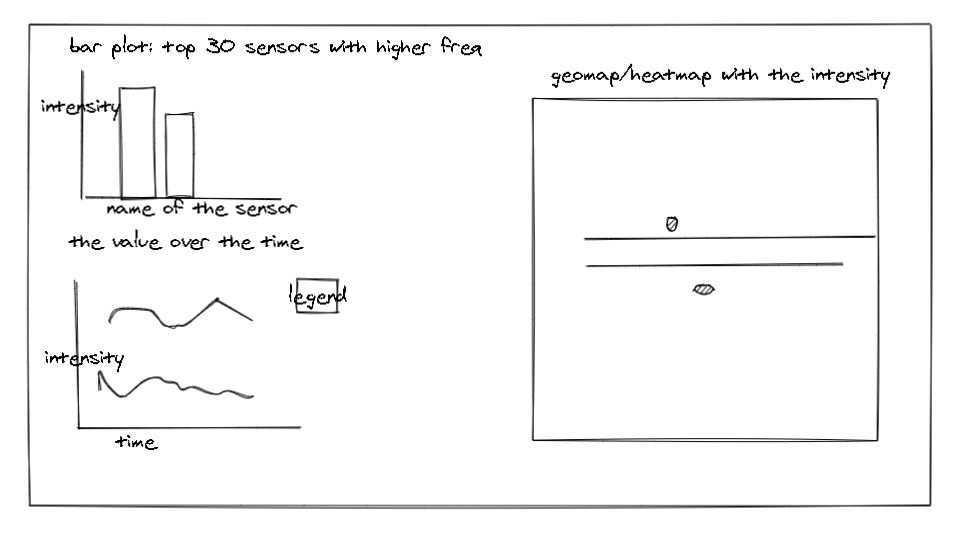

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

#### Measures


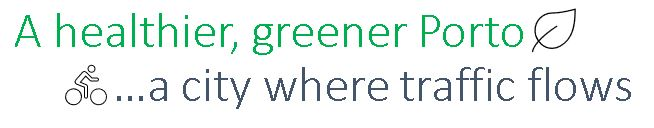



This section is to **propose short term measures** that can be implemented based **on our 72 hours traffic flow forecast** (Primary measures). Also we can derive **medium-long term strategic measures** to **improve the traffic flow** over time (Secondary measures). We also recommend to implement a reporting/ monitoring system to understand the impact of the introduced measures e.g. does the traffic flow improve, air pollution and noise decreases. When measure dont have the desired impact other measures have to be considered. We see this a continous improvment process depending on the target set. 






##### Primary measures


We suggest implementation of a "traffic light system" for individual parts of the city. This could involve for example emission reduction zones ([Zonas de Emissões Reduzidas](https://24.sapo.pt/atualidade/artigos/campo-aberto-defende-zonas-de-emissoes-reduzidas-na-revisao-do-plano-diretor-municipal-do-porto))

**Low Emission Zones:**

Lisbon has already implemented low emission zones [Lisbon Low Emission Zone](https://urbanaccessregulations.eu/countries-mainmenu-147/portugal/lisbon). This could be an example that Porto could follow as well. It involves:

1. a vehicle meets the required emissions standard and
2. it qualifes to get a permit (Sticker) to enter in the area
3. on-street parking is for residents only (red sticker), blue and green stickers can park in off-street car parks

The following image different zones with different rules for Lisbon:



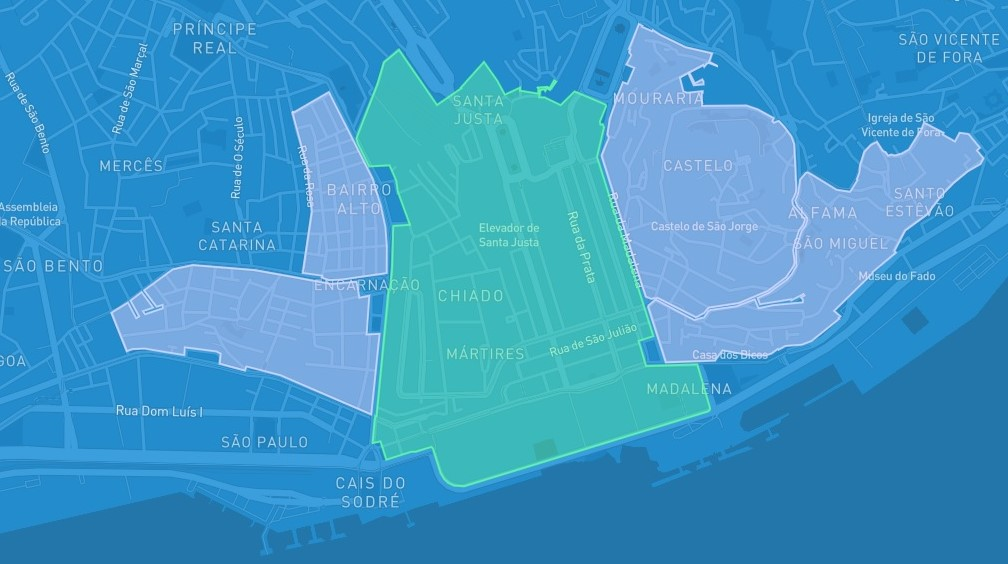

In various other european cities this measures showed significant improvments:

For example in Berlin the main focus for low emission zones is as follows [Berlin: low emission zone](https://www.berlin.de/sen/uvk/en/environment/low-emission-zone/)
Mainly, the low emission zone focuses on the **reduction of diesel exhaust particles**. These particles are especially harmful and increase the risk of pulmonary and cardio-vascular diseases. Moreover, diesel particles are classified as cancerogenous.

The low emission zone was not introduced to decrease the output of carbon dioxide (CO2), a climate-damaging gas. Nevertheless, **it supports climate protection**, as diesel particles contributes to the global warming as well and are now classified as one of the most important climate drivers after CO2.

A study on the german city Leipzig shows that low emission zones do work [Study Leipzig](https://www.internationales-verkehrswesen.de/studie-umweltzone-leipzig/). Fine particles could be reduced by almost 50% between 2010 and 2016. Even though nitrogen oxides (NOx) have not decreases this is mainly due to the increase of diesel cars from 19% to 26%.


The boundaries for the **different bandings** would need to be defined by a metric that takes into account traffic flow, air pollution and traffic noise and other factors if applicable.

**Blue (low traffic)**

*   in areas with more footfall, e.g. city centre of Porto
decrease the traffic light cycle times so people can safer cross streets
* close of street/ areas for certain times of the day to make it safer and enjoyable for pedestrians

**Yellow (medium traffic)**

* increase traffic light cycle times, that means people have to wait longer to cross the street, but it improves the traffic flow
* increase/ optimise public transport routes were suitable


**Red (high traffic)**

* increase traffic light cycle times, that means people have to wait longer to cross the street, but it improves the traffic flow
* rerouting to less frequent street/ road using street using App or digital road signs that can implemented across the city 
*  increase/ optimise public transport routes were suitable; the city could explore free public transport for certain areas to motivate people to use the metro/ bus instead of driving




##### Secondary measures

Improve traffic flow by shifting to other forms of transport:

# Cycling

In the 1950s the bicycle mode share was over 50% and dropping in the following decades to 8% in the 1970s to just about 0.5% in 2011 [Portugal, Europe's next cycling nation?](https://ecf.com/news-and-events/news/portugal-europes-next-cycling-nation-blog-post-b-c-pereira).

We understand that Porto as already introduced more cycle lanes to become a more cycle friendly city [Porto is on its way to being a bike friendly city](https://www.porto.pt/en/news/porto-is-on-its-way-to-being-a-bike-friendly-city)

Although Porto faces some challenges for cycling due to its hills. There are measures that can be taken to increase the number of cycle users. 

**Health Benefits**

A study in Denmark show if people would cycle just 10% more a year
[Biking in Denmark](https://denmark.dk/people-and-culture/biking). This would have the following benefits:

*   267,000 fewer sick days
*   6 % less traffic congestion in the major cities
*   DKK 1.1 billion (~EUR 134 million) saved in the public health care system

**Cycle to work schemes:**

This schemes are fairly popular in the UK:

"Cycle to Work scheme is a UK Government tax exemption initiative introduced in the Finance Act 1999 to promote healthier journeys to work and to reduce environmental pollution. It allows employers to loan cycles and cyclists' safety equipment to employees as a tax-free benefit." [Cycle to Work scheme](https://en.wikipedia.org/wiki/Cycle_to_Work_scheme)

**Implementation of Bike Sharing system**

This could be a partially subsides solution to implement a similar bike sharing system to Lisbon [Lisbon launches electric bike share system](https://www.theguardian.com/cities/2017/aug/03/hilly-lisbon-portugal-electric-bike-share-congestion). This a hybrid system currently operating with 600 pedelec and conventional bicycles served by 81 stations.

**Off Road Cycle Lanes and Cycle Highways**

Off road cycles lanes are a safer solution to on road cycles lanes. Off road cycles have the disadvantage that they cant be used for cars as well, but offer a much safer cyle commute. The city of Porto should consider to implement off road cycle lanes were suitable. Cycle highways are also possible options to consider for long distance travelling.

# Public Transport

A well connected and efficient public transport system is crucial for a citys transport system. The better service and more routes fit peoples need the more likly people will use public transport options than their own cars and being stuck in traffic. Here suggest the following measures:

* review areas with high traffic/ conjections and identify where people travel from/to so this could possible routes to be improved, more frequent.
* to ensure this works we suggest to increase the number of bus lanes
* explore better ways of public transport (e.g. as mentioned in car sharing)

# Car Sharing

We also suggest to improve the access to car sharing. It is an innovative urban mobility concept, that include the only use of electric or hydrogren cars to decrease air and noise pollution on the one hand, also it will has some benefits for parking as multple people can share a car.

# Trees and Vertical Gardens

Trees act as sound barriers and reduce traffic noise and improves air quality [Trees as sound barriers](https://greenblue.com/gb/trees-as-sound-barriers/#:~:text=Where%20space%20permits%2C%20thick%20strips,for%20use%20as%20sound%20barriers.) We suggest to review areas/ streets to plant more trees. Further we also suggest the implementation vertical gardens especially arround motorsways they seems to be very effective to reduce noise levels [Vertical Gardens Motorways](http://www.andalusianstories.com/the-story-of-the-day/sustainability/news-andalusia-vertical-gardens-motorways-noise-pollution/)



### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀

- Understand better the data quality and pre-processing (missing values, outliers)
- Use more data, for example POIs
- Take in consideration in the sensor position the flow direction
- Create a final dashboard with all the analysis
- consider to use noise data to impute missing values for the traffic intensity